In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# The following code was used to scrap data from www.basketball-reference.com. The idea is to use 23 characteristics that describe standarized role's player during a season. These data was in multiple tables, and was taken for multiple years. 

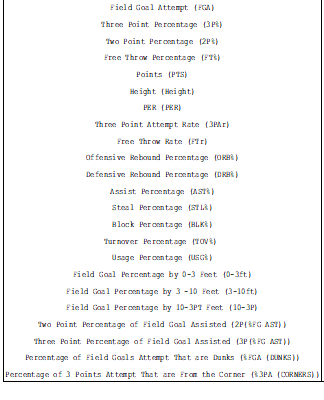

In [2]:
# NBA season we will be analyzing
def all_tables(year, db):
    lst_4=[]
    if db == 'per_poss':
        url = "https://www.basketball-reference.com/leagues/NBA_{}_{}.html".format(year,db)
        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html)
        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers
        # avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        stats = pd.DataFrame(player_stats, columns = headers)
        
        tags=soup.findAll('a')
        lst=list()
        for tag in tags:
            lst.append(tag.get('href',None))

        b='http://basketball-reference.com'
        lst_1=list()
        for a in lst:
            if a.startswith('/players'):
                c=b+a
                lst_1.append(c)
        lst_1=lst_1[7:]
        lst_1=lst_1[:-22]


        lst_3=list()
        for d in lst_1:
            url=d
            html=urlopen(url)
            soup = BeautifulSoup(html)

            tags=soup.findAll('span')
            lst_2=list()
            for tag in tags:
                if tag.get('itemprop') != None:
                    if len(tag.contents) > 0:
                        lst_2.append(tag.contents[0])
            lst_3.append(lst_2[6])
            
        stats=stats.dropna()
        stats['Height'] = lst_3
        stats = stats.where(stats['Tm'] != 'TOT')
        stats=stats.dropna()
        stats=stats.replace(r'^\s*$', .000, regex=True)
        stats=stats.replace({'.':'0.'})
        team=stats['Tm'].to_list()
        height=stats['Height'].to_list()
        col_drop=['Pos','Age','Height','Tm','G','GS','MP','FG','FG%','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF',
                  'ORtg','DRtg','']
        stats=stats.drop(col_drop,axis=1)
        for change in stats['Player']:
            year=str(year)
            c=change +' '+ year
            lst_4.append(c)
        stats['Player'] = lst_4
        
        stats=stats.set_index('Player')
        stats=stats.astype('float64')
        stats['Height'] = height
        stats['Tm'] = team
    
    elif db == 'advanced':
        lst=[]
        url = "https://www.basketball-reference.com/leagues/NBA_{}_{}.html".format(year,db)
        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html)
        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        #avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                        for i in range(len(rows))]
        stats = pd.DataFrame(player_stats, columns = headers)
        stats = stats.where(stats['Tm'] != 'TOT')
        stats=stats.dropna()
        stats=stats.replace(r'^\s*$', 0, regex=True)
        stats=stats.replace({'.':'0.'})
        col_drop=['Pos','Age','Tm','G','MP','TS%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP','TRB%']
        stats=stats.drop(col_drop,axis=1)
        for change in stats['Player']:
            year=str(year)
            c=change +' '+ year
            lst.append(c)
        stats['Player'] = lst

        stats=stats.iloc[:,:-2].set_index('Player')
        stats=stats.astype('float64')
        
    elif db == 'shooting':
        lst=[]
        url = "https://www.basketball-reference.com/leagues/NBA_{}_{}.html".format(year,db)
        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html,'html.parser')
        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        #use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        #avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        stats = pd.DataFrame(player_stats, columns = headers)
        stats = stats.where(stats['Tm'] != 'TOT')
        stats=stats.dropna()
        stats=stats.replace(r'^\s*$', 0, regex=True)
        stats=stats.replace({'.':'0.'})
        col_drop=['Pos','Age','Tm','G','MP','Dist.','Att.','#','FG%']
        stats=stats.drop(col_drop,axis=1)
        stats=stats.iloc[:,[0,3,4,5,6,16,17,19,21]]
        
        for change in stats['Player']:
            year=str(year)
            c=change +' '+ year
            lst.append(c)
        stats['Player'] = lst
        
        stats=stats.set_index('Player')
        stats=stats.astype('float64')        
        stats['10-3P']=(stats['10-16'] + stats['16-3P'])/2
        stats=stats.drop(['10-16','16-3P'],axis=1)
        
    else:
        print('No hay tabla')

    return stats

In [ ]:
a=all_tables(2009,'per_poss')
b=all_tables(2009,'advanced')
c=all_tables(2009,'shooting')
d=all_tables(2010,'per_poss')
e=all_tables(2010,'advanced')
f=all_tables(2010,'shooting')

final_df=pd.concat([a,b,c],axis=1)
final_df1=pd.concat([d,e,f],axis=1)
final_df2=final_df1.append(final_df)

g=all_tables(2011,'per_poss')
h=all_tables(2011,'advanced')
i=all_tables(2011,'shooting')
j=all_tables(2012,'per_poss')
k=all_tables(2012,'advanced')
l=all_tables(2012,'shooting')

final_df3=pd.concat([g,h,i],axis=1)
final_df4=pd.concat([j,k,l],axis=1)
final_df5=final_df2.append([final_df3,final_df4])

In [ ]:
m=all_tables(2013,'per_poss')
n=all_tables(2013,'advanced')
o=all_tables(2013,'shooting')
p=all_tables(2014,'per_poss')
q=all_tables(2014,'advanced')
r=all_tables(2014,'shooting')

final_df6=pd.concat([m,n,o],axis=1)
final_df7=pd.concat([p,q,r],axis=1)
final_df8=final_df5.append([final_df6,final_df7])

In [ ]:
s=all_tables(2015,'per_poss')
t=all_tables(2015,'advanced')
u=all_tables(2015,'shooting')
v=all_tables(2016,'per_poss')
w=all_tables(2016,'advanced')
x=all_tables(2016,'shooting')

final_df9=pd.concat([s,t,u],axis=1)
final_df10=pd.concat([v,w,x],axis=1)
final_df11=final_df8.append([final_df9,final_df10])

In [ ]:
y=all_tables(2017,'per_poss')
z=all_tables(2017,'advanced')
aa=all_tables(2017,'shooting')
ab=all_tables(2018,'per_poss')
ac=all_tables(2018,'advanced')
ad=all_tables(2018,'shooting')

final_df12=pd.concat([y,z,aa],axis=1)
final_df13=pd.concat([ab,ac,ad],axis=1)
final_df14=final_df11.append([final_df12,final_df13])

In [ ]:
ae=all_tables(2019,'per_poss')
af=all_tables(2019,'advanced')
ag=all_tables(2019,'shooting')

final_df15=pd.concat([ae,af,ag],axis=1)
final_df16=final_df14.append([final_df15])
#final_df16.to_csv('#name.csv')

In [ ]:
final_df16 #Final data frame with the name of each player and the year, and all the 23 characteristics selected. 

# Between the Data_2009_2019.csv and this final dataframe, there are some columns missing. 